## **TD3 for Pendulum-v1**

**The TD3 (Twin Delayed DDPG) algorithm** is a modification of the DDPG (Deep Deterministic Policy Gradient) algorithm aimed at improving its stability and performance.
TD3 uses two Q-functions (critics) to evaluate the value of actions. This helps to reduce the overestimation of the value of actions that can occur in learning with a single critic. During training, the smaller of the two Q-functions is chosen to reduce error sensitivity.
This algorithm uses Delayed Policy Updates. This approach is to update the policy (strategy) less often than the critics. It also helps to avoid too abrupt a change in strategy, which can lead to learning failure.
To combat the discontinuities in strategy that can occur due to periodic updates, TD3 uses artificially added noise to selected actions to help smooth out strategic changes.

In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal

In [4]:
actor_lr_td3 = 0.001
critic_lr_td3 = 0.002
gamma_td3 = 0.99
tau_td3 = 0.005
buffer_size_td3 = 10000
batch_size_td3 = 64
sigma_td3 = 0.2
noise_clip_td3 = 0.5
policy_freq_td3 = 2

In [5]:
env = gym.make("Pendulum-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
class ActorTD3(nn.Module):
   def __init__(self, state_dim, action_dim, max_action):
       super(ActorTD3, self).__init__()
       self.fc1 = nn.Linear(state_dim, 400)
       self.fc2 = nn.Linear(400, 300)
       self.fc3 = nn.Linear(300, action_dim)
       self.max_action = max_action

   def forward(self, state):
       x = torch.relu(self.fc1(state))
       x = torch.relu(self.fc2(x))
       x = torch.tanh(self.fc3(x)) * self.max_action
       return x

In [7]:
class CriticTD3(nn.Module):
   def __init__(self, state_dim, action_dim):
       super(CriticTD3, self).__init__()
       self.fc1 = nn.Linear(state_dim + action_dim, 400)
       self.fc2 = nn.Linear(400, 300)
       self.fc3 = nn.Linear(300, 1)

   def forward(self, state, action):
       x = torch.cat([state, action], dim=1)
       x = torch.relu(self.fc1(x))
       x = torch.relu(self.fc2(x))
       x = self.fc3(x)
       return x

In [8]:
class TD3Agent:
   def __init__(self, state_dim, action_dim, max_action, actor_lr, critic_lr, gamma, tau, buffer_size, batch_size, sigma, noise_clip, policy_freq):
       self.actor = ActorTD3(state_dim, action_dim, max_action)
       self.actor_target = ActorTD3(state_dim, action_dim, max_action)
       self.actor_target.load_state_dict(self.actor.state_dict())
       self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

       self.critic1 = CriticTD3(state_dim, action_dim)
       self.critic2 = CriticTD3(state_dim, action_dim)
       self.critic1_target = CriticTD3(state_dim, action_dim)
       self.critic2_target = CriticTD3(state_dim, action_dim)
       self.critic1_target.load_state_dict(self.critic1.state_dict())
       self.critic2_target.load_state_dict(self.critic2.state_dict())
       self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=critic_lr)
       self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=critic_lr)

       self.max_action = max_action
       self.gamma = gamma
       self.tau = tau
       self.sigma = sigma
       self.noise_clip = noise_clip
       self.policy_freq = policy_freq

       self.buffer_size = buffer_size
       self.batch_size = batch_size
       self.buffer = []

   def select_action(self, state):
       state = torch.FloatTensor(state.reshape(1, -1))
       return self.actor(state).cpu().data.numpy().flatten()

   def train(self):
       if len(self.buffer) < self.batch_size:
           return

       batch = np.random.choice(len(self.buffer), self.batch_size, replace=False)
       states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in batch])

       state_batch = torch.FloatTensor(states)
       action_batch = torch.FloatTensor(actions)
       reward_batch = torch.FloatTensor(rewards)
       next_state_batch = torch.FloatTensor(next_states)
       done_batch = torch.FloatTensor(dones)

       noise = torch.FloatTensor(actions).data.normal_(0, self.sigma)
       noise = torch.clamp(noise, -self.noise_clip, self.noise_clip)
       next_action = (self.actor_target(next_state_batch) + noise).clamp(-self.max_action, self.max_action)

       target_Q1 = self.critic1_target(next_state_batch, next_action)
       target_Q2 = self.critic2_target(next_state_batch, next_action)
       target_Q = torch.min(target_Q1, target_Q2)
       target_Q = reward_batch + self.gamma * (1 - done_batch) * target_Q


       current_Q1 = self.critic1(state_batch, action_batch)
       current_Q2 = self.critic2(state_batch, action_batch)
       critic1_loss = nn.MSELoss()(current_Q1, target_Q.detach())
       critic2_loss = nn.MSELoss()(current_Q2, target_Q.detach())

       self.critic1_optimizer.zero_grad()
       critic1_loss.backward()
       self.critic1_optimizer.step()

       self.critic2_optimizer.zero_grad()
       critic2_loss.backward()
       self.critic2_optimizer.step()

       if len(self.buffer) % self.policy_freq == 0:
           actor_loss = -self.critic1(state_batch, self.actor(state_batch)).mean()

           self.actor_optimizer.zero_grad()
           actor_loss.backward()
           self.actor_optimizer.step()

           for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
               target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

           for param, target_param in zip(self.critic1.parameters(), self.critic1_target.parameters()):
               target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

           for param, target_param in zip(self.critic2.parameters(), self.critic2_target.parameters()):
               target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [9]:
td3_agent = TD3Agent(state_dim, action_dim, max_action, actor_lr_td3, critic_lr_td3, gamma_td3, tau_td3, buffer_size_td3, batch_size_td3, sigma_td3, noise_clip_td3, policy_freq_td3)

In [10]:
td3_episode_rewards = []
total_timesteps_td3 = []

In [11]:
num_episodes = 100


for episode in range(num_episodes):
   state = env.reset()
   episode_reward = 0

   for t in range(1000):
       action = td3_agent.select_action(state)

       next_state, reward, done, _ = env.step(action)
       td3_agent.buffer.append((state, action, reward, next_state, done))
       td3_agent.train()

       state = next_state
       episode_reward += reward
       total_timesteps_td3.append(len(total_timesteps_td3) + 1)  # Update total_timesteps

       if done:
           break

   td3_episode_rewards.append(episode_reward)
   print(f"TD3 Episode: {episode + 1}, Reward: {episode_reward}")

TD3 Episode: 1, Reward: -1417.5863848196445
TD3 Episode: 2, Reward: -1049.026742018775
TD3 Episode: 3, Reward: -1383.2790348740202
TD3 Episode: 4, Reward: -1054.462831620562
TD3 Episode: 5, Reward: -1542.3915784111266
TD3 Episode: 6, Reward: -1857.8400406005435
TD3 Episode: 7, Reward: -1696.5687550191064
TD3 Episode: 8, Reward: -1370.9012208422605
TD3 Episode: 9, Reward: -1368.2104908212548
TD3 Episode: 10, Reward: -1351.874544584407
TD3 Episode: 11, Reward: -1229.7566439737259
TD3 Episode: 12, Reward: -1568.091159450466
TD3 Episode: 13, Reward: -1559.172950410114
TD3 Episode: 14, Reward: -1452.565318227076
TD3 Episode: 15, Reward: -1167.7074857447603
TD3 Episode: 16, Reward: -1351.935008142279
TD3 Episode: 17, Reward: -1547.8119665865206
TD3 Episode: 18, Reward: -1044.0631276240738
TD3 Episode: 19, Reward: -1052.9725730678417
TD3 Episode: 20, Reward: -1594.2246439415849
TD3 Episode: 21, Reward: -1616.5128503665296
TD3 Episode: 22, Reward: -901.2788637265489
TD3 Episode: 23, Reward: -8

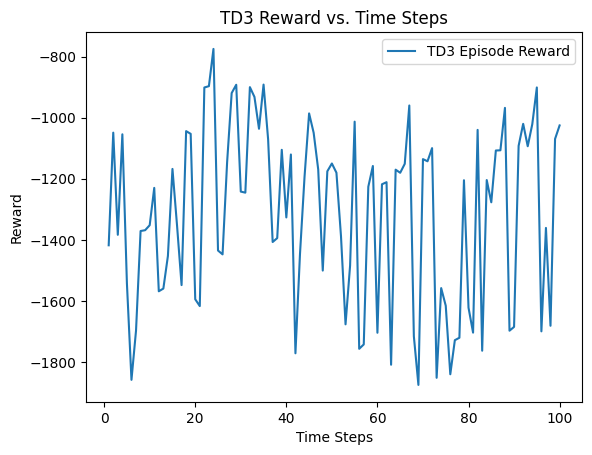

In [12]:
plt.plot(total_timesteps_td3[:len(td3_episode_rewards)], td3_episode_rewards, label='TD3 Episode Reward')
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.title("TD3 Reward vs. Time Steps")
plt.legend()
plt.show()


env.close()